In [6]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpmax, fpgrowth
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import re
import numpy as np
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [7]:
def stemming(content):
    port_stem = PorterStemmer()
    stop_words = stopwords.words('english')

    stemmed_content = re.sub('[^a-zA-Z]',' ',content)
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stop_words]
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content

In [8]:
%%time
train = pd.read_csv(r'C:\Users\user\Desktop\Μεταπτυχιακό\Εργασίες\Data Mining\Χαλκίδη\data\train.csv')
test = pd.read_csv(r'C:\Users\user\Desktop\Μεταπτυχιακό\Εργασίες\Data Mining\Χαλκίδη\data\test.csv')
submit = pd.read_csv(r'C:\Users\user\Desktop\Μεταπτυχιακό\Εργασίες\Data Mining\Χαλκίδη\data\submit.csv')

test = pd.merge(test,submit,on='id')
total = pd.concat([train,test])

total = total.fillna('')
total = total.loc[total['text'] != '']

Wall time: 1.58 s


In [9]:
%%time
total['text'] = total['text'].apply(stemming)

Wall time: 5min 25s


In [20]:
total

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,hous dem aid even see comey letter jason chaff...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,ever get feel life circl roundabout rather hea...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,truth might get fire octob tension intellig an...,1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,video civilian kill singl us airstrik identifi...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,print iranian woman sentenc six year prison ir...,1
...,...,...,...,...,...
5195,25995,The Bangladeshi Traffic Jam That Never Ends - ...,Jody Rosen,dysfunct plagu world megac none may pernici ba...,0
5196,25996,John Kasich Signs One Abortion Bill in Ohio bu...,Sheryl Gay Stolberg,washington gov john kasich ohio tuesday sign l...,1
5197,25997,"California Today: What, Exactly, Is in Your Su...",Mike McPhate,good morn want get california today email joan...,0
5198,25998,300 US Marines To Be Deployed To Russian Borde...,,previou next us marin deploy russian border no...,1


In [19]:
texts = np.asarray(total['text'])

In [21]:
labels = np.asarray(total['label'])

In [27]:
%%time
vect = CountVectorizer().fit(texts)

Wall time: 7.96 s


In [33]:
%%time
X = vect.transform(texts)

Wall time: 7.47 s


In [105]:
col = np.asarray(vect.get_feature_names_out())

In [136]:
%%time
data = []
for doc in range(X.shape[0]):
    row = []
    indices = X[doc,:].nonzero()
    for ind in indices[1]:
        for times in range(X[doc,ind]):
            row.append(col[ind])
    data.append(row)

Wall time: 2min 57s


In [142]:
%%time
te = TransactionEncoder()
te_ary = te.fit(data).transform(data)
df = pd.DataFrame(te_ary, columns=te.columns_)

frequent_itemsets = fpgrowth(df, use_colnames=True)

Wall time: 10.6 s


In [143]:
frequent_itemsets

,support,itemsets
0,0.614664,(one)
1,0.557756,(time)
2,0.540687,(also)
3,0.536719,(year)
4,0.535717,(like)
5,0.622255,(said)
6,0.537220,(peopl)
7,0.508168,(new)
8,0.544579,(would)
9,0.509324,(state)


In [151]:
from mlxtend.frequent_patterns import association_rules

ar = association_rules(frequent_itemsets, metric='lift')
ar.shape

(0, 9)

In [300]:
%%time
reliable = []
unreliable = []
for i in range(labels.shape[0]):
    if labels[i] == 1:
        unreliable.append(data[i])
    elif labels[i] == 0:
        reliable.append(data[i])

Wall time: 31.3 ms


In [303]:
%%time
te = TransactionEncoder()
te_ary = te.fit(reliable).transform(reliable)
df = pd.DataFrame(te_ary, columns=te.columns_)

frequence_reliable = fpgrowth(df, min_support=.3, use_colnames=True)

Wall time: 20.9 s


In [301]:
%%time
te = TransactionEncoder()
te_ary = te.fit(unreliable).transform(unreliable)
df = pd.DataFrame(te_ary, columns=te.columns_)

frequence_unreliable = fpgrowth(df, min_support=.3, use_colnames=True)

Wall time: 5.75 s


In [185]:
import matplotlib.pyplot as plt

In [304]:
print('Support of Words in Unreliable News')
frequence_reliable.sort_values('support', ascending=False).head(10)

Support of Words in Unreliable News


,support,itemsets
0,0.828697,(said)
1,0.745875,(one)
46,0.687647,(also)
60,0.683404,(would)
2,0.672167,(year)
3,0.671696,(time)
4,0.649143,(like)
5,0.647886,(peopl)
6,0.644272,(new)
100,0.638300,"(one, said)"


In [302]:
print('Support of Words in Unreliable News')
frequence_unreliable.sort_values('support', ascending=False).head(10)

Support of Words in Unreliable News


,support,itemsets
0,0.488434,(one)
1,0.448140,(time)
8,0.430753,(peopl)
2,0.426595,(like)
19,0.423647,(said)
9,0.411022,(would)
10,0.409737,(state)
3,0.406411,(year)
4,0.399305,(also)
24,0.377230,(new)


In [200]:
frequence_unreliable.shape

(27, 2)

In [201]:
frequence_reliable.shape

(1949, 2)

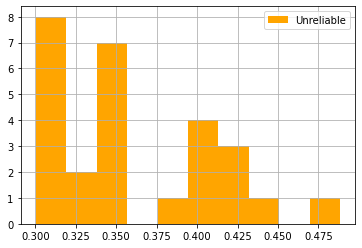

In [225]:
frequence_unreliable['support'].hist(label='Unreliable', color='orange')
plt.legend()
plt.show()

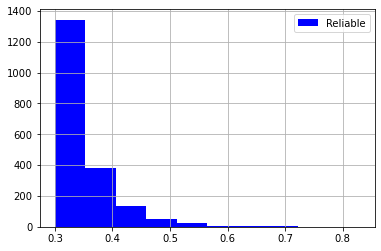

In [226]:
frequence_reliable['support'].hist(label='Reliable', color='blue')
plt.legend()
plt.show()

In [234]:
from mlxtend.frequent_patterns import association_rules

In [289]:
association_rules(frequence_unreliable, min_threshold=.0)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(time),(one),0.448140,0.488434,0.309268,0.690115,1.412914,0.090381,1.650825
1,(one),(time),0.488434,0.448140,0.309268,0.633184,1.412914,0.090381,1.504458


In [305]:
association_rules(frequence_reliable, metric='lift', min_threshold=1.5).sort_values('lift', ascending=False).head(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
6,(donald),(trump),0.325947,0.446409,0.319582,0.980473,2.196355,0.174076,28.349331
7,(trump),(donald),0.446409,0.325947,0.319582,0.715895,2.196355,0.174076,2.372550
21,(unit),"(would, state)",0.410262,0.464875,0.300016,0.731278,1.573063,0.109295,1.991367
18,"(would, state)",(unit),0.464875,0.410262,0.300016,0.645368,1.573063,0.109295,1.662959
3,"(trump, said)",(presid),0.379066,0.547933,0.325240,0.858002,1.565887,0.117536,3.183605
4,(presid),"(trump, said)",0.547933,0.379066,0.325240,0.593575,1.565887,0.117536,1.527794
9,(new),(york),0.644272,0.304495,0.304180,0.472131,1.550538,0.108003,1.317571
8,(york),(new),0.304495,0.644272,0.304180,0.998968,1.550538,0.108003,344.611917
1,(trump),(presid),0.446409,0.547933,0.378595,0.848090,1.547798,0.133993,2.975887
0,(presid),(trump),0.547933,0.446409,0.378595,0.690951,1.547798,0.133993,1.791272


A priori approximation

In [262]:
from mlxtend.frequent_patterns import apriori

te = TransactionEncoder()
te_ary = te.fit(reliable).transform(reliable)
reliableDF = pd.DataFrame(te_ary, columns=te.columns_)

te = TransactionEncoder()
te_ary = te.fit(unreliable).transform(unreliable)
unreliableDF = pd.DataFrame(te_ary, columns=te.columns_)

reliableApriori = apriori(reliableDF, min_support=0.6, use_colnames=True)
unreliableApriori = apriori(unreliableDF, min_support=0.3, use_colnames=True)

In [306]:
reliableApriori['length'] = reliableApriori['itemsets'].apply(lambda x: len(x))
unreliableApriori['length'] = unreliableApriori['itemsets'].apply(lambda x: len(x))

In [268]:
reliableApriori.sort_values('length', ascending=False).head()

,support,itemsets,length
10,0.638300,"(one, said)",2
11,0.601053,"(would, said)",2
0,0.687647,(also),1
1,0.649143,(like),1
2,0.644272,(new),1


In [307]:
unreliableApriori.sort_values('support', ascending=False).head()

,support,itemsets,length
12,0.488434,(one),1
20,0.448140,(time),1
13,0.430753,(peopl),1
8,0.426595,(like),1
16,0.423647,(said),1
